In [2]:
import requests
import pandas as pd
import numpy as np
from io import StringIO
from datetime import datetime, timedelta
import webbrowser
import contextily as cx

import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from geodatasets import get_path

import folium


ImportError: DLL load failed while importing _version: The specified procedure could not be found.

In [ ]:
# min_lon, min_lat, max_lon, max_lat
# Cordenadas de texas
texas_extent_str = ["-106.6","25.8", "-93.5","36.5"]
texas_extent_int = [-107.1,26.3, -93.0,36.0]

california_extent_str = ["-120.8", "34.5", "-114.1", "42.5"]
california_extent_int = [-121.8, 33.5, -113.1, 41.0]

texas_limit = ",".join(texas_extent_str)
print(texas_limit)
california_limit = ",".join(california_extent_str)
print(california_limit)
map_key = "52536e8e34cf07bde80f3177cdcd7771"

# Fire season is summer  june_1 to september 28  june(31), july(30) august(31), september(30)
start_date = datetime(2023, 1, 1)
days = 330
iterations = int(days/10)

## file path
texas_dt_file = "./documents/texas_df.csv"
california_dt_file = "./documents/california_df.csv"

-106.6,25.8,-93.5,36.5
-120.8,34.5,-114.1,42.5


## Functions

### Download  and clean data

In [ ]:
def read_csv_file(path): 
    try:
        df = pd.read_csv(path) 
        print(f"Excel {path} read correctly, size {df.shape}" )
    except FileNotFoundError:
        print(f"El archivo '{path}' no se encontró.")
    except Exception as e:
        print(f"Ocurrió un error al leer el archivo: {str(e)}")
    return df

def read_excel_file(response, iteration,requests_day):
    try:
        df = pd.read_csv(StringIO(response))
        print(f"Response {iteration} -- {requests_day} read correctly with {len(df)} fires detected")
        return df
    except FileNotFoundError:
        print(f"The file '{response}' was not found.")
        return None
    except pd.errors.ParserError:
        print("Error while parsing the file.")
        return None
def save_transformed_data(df, output_path):
    if df is not None:
        try:
            df.to_csv(output_path, index=False)
            print("Data Frame saved correctly ")

        except Exception as e:
            print(f"An error occurred while saving the transformed data: {str(e)}")

def dowload_and_tranform_data(cordate_list,map_key,start_date,iterations):
    data_frames = []
    requests_day = start_date
    for i in range(iterations):
        url_test = f"https://firms.modaps.eosdis.nasa.gov/api/area/csv/{map_key}/VIIRS_SNPP_NRT/{cordate_list}/10/{requests_day.strftime('%Y-%m-%d')}"
        # url_test = f"https://firms.modaps.eosdis.nasa.gov/api/area/csv/{map_key}/LANDSAT_NRT/{cordate_list}/10/{requests_day.strftime('%Y-%m-%d')}"
        response = requests.get(url_test)
        if response.status_code == 200:
            df = read_excel_file(response.text, i,requests_day)
            data_frames.append(df)
            
        else:
            print(f"Error en la solicitud: {response.status_code}")
        requests_day += timedelta(days=10)
    final_df = pd.concat(data_frames, ignore_index=True)
    return final_df

We round the data to close the point we a diference of 1 metter 

0.001 grado = 111 metros            
0.0001 grado = 11.1 metros          
0.00001 grado = 1.11 metros         

In [3]:
def drop_duplicates(df):
    df = df.drop_duplicates()
    df['latitude'] = df['latitude'].round(4)
    df['longitude'] = df['longitude'].round(4)
    df = df.groupby(["latitude", "longitude","acq_date"]).agg(
        acq_time=pd.NamedAgg(column='acq_time', aggfunc='last'),
        satellite = pd.NamedAgg(column='satellite', aggfunc="last")
    ).reset_index()

    df = df.sort_values(["longitude","latitude","acq_time"])
    df['lat_diff'] = df['latitude'].diff()
    df['lon_diff'] = df['longitude'].diff()
    return df



### Clasify fire 

In [ ]:
def is_in_buffer(lat_lon_range, longitude, latitude):
    result = (longitude > lat_lon_range[0]) & (longitude < lat_lon_range[2]) & (latitude > lat_lon_range[1]) & (latitude < lat_lon_range[3])
    return result


def update_buffer(lat_lon_range, min_lon, min_lat, max_lon, max_lat,degres_start ):
    lat_lon_range[0] = min_lon - degres_start
    lat_lon_range[1] = min_lat - degres_start
    lat_lon_range[2] = max_lon + degres_start
    lat_lon_range[3] = max_lat + degres_start
    return lat_lon_range

def grow_the_buffer(lat_lon_range, lon_diff,lat_diff,degres_plus):
    if(lon_diff>0):
        lat_lon_range[2] + degres_plus 
    else : 
        lat_lon_range[0] - degres_plus
    if(lat_diff>0):
        lat_lon_range[3] + degres_plus 
    else : 
        lat_lon_range[1] - degres_plus
    return lat_lon_range

def identify_same_fire(group_position):
    # min_lon, min_lat, max_lon, max_lat
    lat_lon_range = [0,0,0,0]
    date  = ""
    degres_plus = round(35 / (111*100),5)
    degres_start = round(45 / (111*100),5)
    current_cluster_id = 0
    group_position['fire_cluster'] = np.nan

    for i in range(0, len(group_position)):
        if(group_position.iloc[i]['acq_date'] != date):
            date = str(group_position.iloc[i]['acq_date'])
            current_cluster_id = 0
            lat_lon_range = [0,0,0,0]

        if (is_in_buffer(lat_lon_range, group_position.iloc[i]['longitude'],group_position.iloc[i]['latitude'])):
            group_position.at[i, 'fire_cluster'] = "fire-" + date + "-" + str(current_cluster_id)
            lat_lon_range = grow_the_buffer(lat_lon_range,group_position.iloc[i]['lon_diff'],group_position.iloc[i]['lat_diff'] ,degres_plus)
        else: 
            lat_lon_range = update_buffer(lat_lon_range, group_position.iloc[i]['longitude'],group_position.iloc[i]['latitude'], group_position.iloc[i]['longitude'],group_position.iloc[i]['latitude'],degres_start)
            current_cluster_id = current_cluster_id + 1
            group_position.at[i, 'fire_cluster'] = "fire-" + date + "-" + str(current_cluster_id)
    return group_position

In [ ]:
def group_fires(identified_fires):
    grouped_fire_df = identified_fires.groupby(['fire_cluster']).agg(
        acq_date=pd.NamedAgg(column='acq_date', aggfunc='first'),        
        min_latitude=pd.NamedAgg(column='latitude', aggfunc='min'),
        max_latitude=pd.NamedAgg(column='latitude', aggfunc='max'),
        min_longitude=pd.NamedAgg(column='longitude', aggfunc='min'),
        max_longitude=pd.NamedAgg(column='longitude', aggfunc='max'),
        detections=pd.NamedAgg(column='latitude', aggfunc='count'),
        mean_latitude=pd.NamedAgg(column='latitude', aggfunc='mean'),
        mean_longitude=pd.NamedAgg(column='longitude', aggfunc='mean'),
        concat_latitude = pd.NamedAgg(column='latitude',  aggfunc=lambda x: list(x)), 
        concat_longitude = pd.NamedAgg(column='longitude',  aggfunc=lambda x: list(x))
    ).reset_index()
    grouped_fire_df['area'] = np.pi * (30 ** 2) * grouped_fire_df['detections']  # Area per detection assuming 30m radius

    return grouped_fire_df

In [ ]:
def clasify_fire(df):
    # Group by the 'Category' column
    grouped = df.groupby('acq_date')
    group_array = []
    fire_numbre_by_day = []
    # Create multiple DataFrames based on the groups
    data_frames = [group for _, group in grouped]
    for i, group_df in enumerate(data_frames):
        identified_fires_df =  identify_same_fire(group_df)
        grouped_fire_df =  group_fires(identified_fires_df)
        group_array.append(grouped_fire_df)
        fire_numbre_by_day.append(len(grouped_fire_df))
    print(f"Total fires in the year are {sum(fire_numbre_by_day)}")
    return group_array

### Graphics

<Axes: >

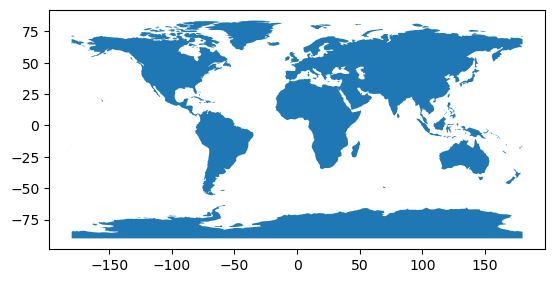

In [ ]:
path = get_path("naturalearth.land")
world = gpd.read_file(path)

# and test our libraries loaded

world.plot()

In [ ]:
def plot_fires_of_day_goepandas(extent, data_frame, title ):
    gdf_all_fires = gpd.GeoDataFrame(
        data_frame,
        geometry=gpd.points_from_xy(data_frame['longitude'], data_frame['latitude']),
        crs="EPSG:4326"
    )
    ax = world.plot(figsize=(10, 10) ,color="grey", edgecolor="black")
    ax.set_xlim([extent[0],  extent[2]])
    ax.set_ylim([extent[1],  extent[3]])
    ax.set(title=title)

    gdf_all_fires.plot(marker='o', color='blue', markersize=5, label='All Fires', ax=plt.gca())
    cx.add_basemap(ax, crs=gdf_all_fires.crs)

    plt.legend()
    plt.show()

## Results

In [ ]:

# data_df = dowload_and_tranform_data(california_limit,map_key,start_date,iterations)
# data_df = drop_duplicates(data_df)
# save_transformed_data(data_df, california_dt_file)



Response 0 -- 2023-01-01 00:00:00 read correctly with 13 fires detected
Response 1 -- 2023-01-11 00:00:00 read correctly with 10 fires detected
Response 2 -- 2023-01-21 00:00:00 read correctly with 74 fires detected
Response 3 -- 2023-01-31 00:00:00 read correctly with 134 fires detected
Response 4 -- 2023-02-10 00:00:00 read correctly with 301 fires detected
Response 5 -- 2023-02-20 00:00:00 read correctly with 92 fires detected
Response 6 -- 2023-03-02 00:00:00 read correctly with 63 fires detected
Response 7 -- 2023-03-12 00:00:00 read correctly with 48 fires detected
Response 8 -- 2023-03-22 00:00:00 read correctly with 110 fires detected
Response 9 -- 2023-04-01 00:00:00 read correctly with 156 fires detected
Response 10 -- 2023-04-11 00:00:00 read correctly with 175 fires detected
Response 11 -- 2023-04-21 00:00:00 read correctly with 159 fires detected
Response 12 -- 2023-05-01 00:00:00 read correctly with 84 fires detected
Response 13 -- 2023-05-11 00:00:00 read correctly with 

### First question  #Fire records 

In [ ]:
texas_df = read_csv_file(texas_dt_file)
print(f"this are the points detected from 2023-01-01 to 2023-11-17 in texas {len(texas_df)}")

Excel ./documents/texas_df.csv read correctly, size (63139, 7)
this are the points detected from 2023-01-01 to 2023-11-17 in texas 63139


In [ ]:
californias_df = read_csv_file(california_dt_file)
print(f"this are the points detected from 2023-01-01 to 2023-11-17 in texas {len(californias_df)}")

Excel ./documents/california_df.csv read correctly, size (9744, 7)
this are the points detected from 2023-01-01 to 2023-11-17 in texas 9744


### Second question #fires

In [ ]:
clasify_fire_dft = clasify_fire(texas_df)

C:\Users\fabri\AppData\Local\Temp\ipykernel_23008\3013208979.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'fire-2023-01-01-1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  group_position.at[i, 'fire_cluster'] = "fire-" + date + "-" + str(current_cluster_id)
C:\Users\fabri\AppData\Local\Temp\ipykernel_23008\3013208979.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'fire-2023-01-02-1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  group_position.at[i, 'fire_cluster'] = "fire-" + date + "-" + str(current_cluster_id)
C:\Users\fabri\AppData\Local\Temp\ipykernel_23008\3013208979.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'fire-2023-01-03-1' has dtype incompatible with flo

Total fires in the year are 51164


In [ ]:
clasify_fire_dfc = clasify_fire(californias_df)

C:\Users\fabri\AppData\Local\Temp\ipykernel_23008\3013208979.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'fire-2023-01-02-1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  group_position.at[i, 'fire_cluster'] = "fire-" + date + "-" + str(current_cluster_id)
C:\Users\fabri\AppData\Local\Temp\ipykernel_23008\3013208979.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'fire-2023-01-06-1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  group_position.at[i, 'fire_cluster'] = "fire-" + date + "-" + str(current_cluster_id)
C:\Users\fabri\AppData\Local\Temp\ipykernel_23008\3013208979.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'fire-2023-01-07-1' has dtype incompatible with flo

Total fires in the year are 7553


### Fourted question #Graphics

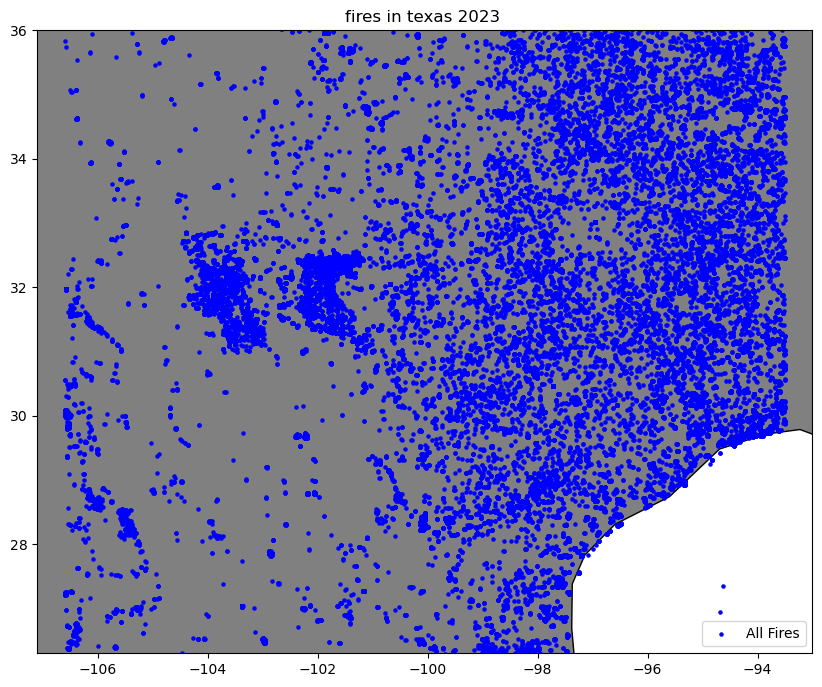

In [ ]:
plot_fires_of_day_goepandas(texas_extent_int,texas_df, "fires in texas 2023 ")

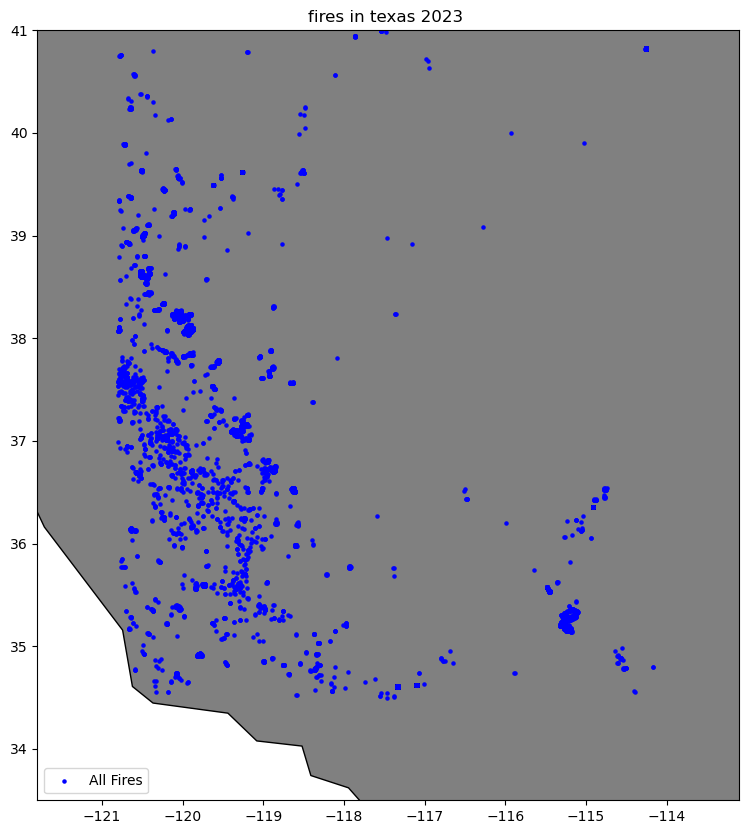

In [ ]:
plot_fires_of_day_goepandas(california_extent_int,californias_df, "fires in california 2023 ")

- Create narrative  
- Improve graphics
- Refinar boundaries 
- Create correlation beetwen days 


Area californioa 423k
Area Texas 695k
